In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from models.utils.common import get_project_root, parse_params

In [13]:
# Load results
experiment_name = "v2_run"
results_dir = os.path.join(get_project_root(), "results", experiment_name)
results = pd.read_csv(os.path.join(results_dir, "optuna_results.csv"))
results.head(1)

,model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg
0,GradientBoosting,"{'n_estimators': 106, 'learning_rate': 0.16323...",0.873101,0.784864,0.646959,0.709256,0.884434,0.811671,0.673227,0.735994,0.026739,False


In [14]:
# Parse params for readability
# Convert stringified dicts to real dicts
results["params"] = results["params"].apply(parse_params)
# Parse params for readability 
params_df = pd.json_normalize(results["params"])
results = pd.concat([results.drop(columns="params"), params_df], axis=1)
results

,model,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg,n_estimators,learning_rate,max_depth,subsample,gamma
0,GradientBoosting,0.873101,0.784864,0.646959,0.709256,0.884434,0.811671,0.673227,0.735994,0.026739,False,106.0,0.163239,3,0.869457,NaN
1,GradientBoosting,0.873101,0.784864,0.646959,0.709256,0.884434,0.811671,0.673227,0.735994,0.026739,False,195.0,0.197239,4,0.724272,NaN
2,GradientBoosting,0.873101,0.784864,0.646959,0.709256,0.884434,0.811671,0.673227,0.735994,0.026739,False,122.0,0.102712,4,0.730156,NaN
3,GradientBoosting,0.873101,0.784864,0.646959,0.709256,0.884434,0.811671,0.673227,0.735994,0.026739,False,127.0,0.145815,3,0.867203,NaN
4,GradientBoosting,0.873101,0.784864,0.646959,0.709256,0.884434,0.811671,0.673227,0.735994,0.026739,False,166.0,0.144827,5,0.647610,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,XGBoost,0.871791,0.782365,0.643023,0.705875,0.877483,0.797404,0.654189,0.718722,0.012848,False,NaN,0.271236,3,0.659007,4.0
66,XGBoost,0.872384,0.784340,0.643622,0.707043,0.876960,0.795474,0.653932,0.717774,0.010731,False,NaN,0.269829,3,0.658518,4.0
67,XGBoost,0.872589,0.784585,0.644477,0.707643,0.877216,0.797546,0.652478,0.717744,0.010101,False,NaN,0.268570,3,0.657915,4.0
68,XGBoost,0.871647,0.782515,0.641996,0.705319,0.877145,0.796758,0.653205,0.717867,0.012548,False,NaN,0.267068,3,0.648423,4.0


In [16]:
# Filter out overfitted trials s
non_overfitted = results[
    (results["overfit"] < 0.05)
    & (
        results["model"] != "RandomForest"
    )  # Exclude RandomForest due to consistent overfitting (not generalizing well)
    & (
        results["mean_test_precision"] > 0.78
    )  # Marketing: minimize false positives
].copy()
print(f"\nNumber of non-overfitted trials: {len(non_overfitted)}")

print(non_overfitted["model"].value_counts())

# Calculate robust F1
non_overfitted["robust_f1"] = (
    non_overfitted["mean_test_f1"] - 0.3 * non_overfitted["overfit"]
)



Number of non-overfitted trials: 53
model
XGBoost             29
GradientBoosting    24
Name: count, dtype: int64


In [ ]:
# Build summary table
summary_cols = [
    "model",
    "mean_test_f1",
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "overfit",
    "params",
]

non_overfitted.groupby("model")[summary_cols].describe().T

In [18]:
# Top 3 per model by robust F1
top_models = []
for model in non_overfitted["model"].unique():
    model_top = non_overfitted[non_overfitted["model"] == model].nlargest(
        3, "robust_f1"
    )
    top_models.append(model_top)
top_models = pd.concat(top_models).reset_index(drop=True)

In [19]:
top_models

,model,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg,n_estimators,learning_rate,max_depth,subsample,gamma,robust_f1
0,GradientBoosting,0.873654,0.787399,0.646531,0.710039,0.881629,0.807496,0.663473,0.728420,0.018381,False,197.0,0.155051,3,0.764411,NaN,0.704524
1,GradientBoosting,0.874043,0.784266,0.653291,0.712810,0.888713,0.819097,0.686532,0.746961,0.034152,False,137.0,0.102284,5,0.806649,NaN,0.702564
2,GradientBoosting,0.873674,0.781792,0.654831,0.712695,0.889470,0.820466,0.688800,0.748874,0.036180,False,133.0,0.110811,5,0.823746,NaN,0.701841
3,XGBoost,0.874596,0.784512,0.656114,0.714581,0.880574,0.798736,0.669633,0.728494,0.013913,False,NaN,0.271882,3,0.604880,4.0,0.710408
4,XGBoost,0.874596,0.784512,0.656114,0.714581,0.880574,0.798736,0.669633,0.728494,0.013913,False,NaN,0.277496,4,0.606491,4.0,0.710408
5,XGBoost,0.873879,0.784407,0.652178,0.712199,0.878557,0.796064,0.662104,0.722900,0.010701,False,NaN,0.273629,4,0.602479,5.0,0.708989


In [8]:
plt.rcParams["figure.figsize"] = (10, 6)

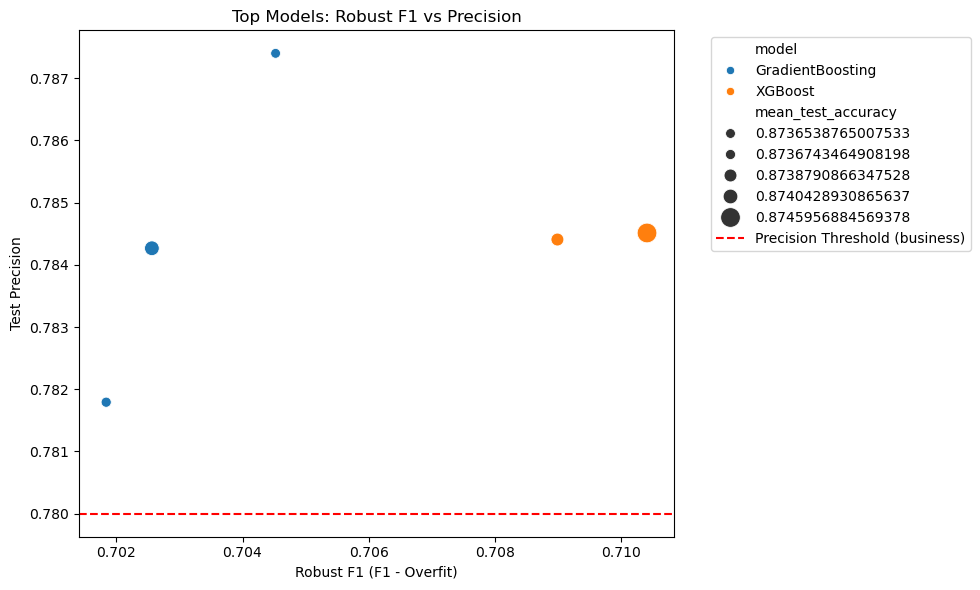

In [20]:
# Scatterplot: Robust F1 vs Precision

sns.scatterplot(
    data=top_models,
    x="robust_f1",
    y="mean_test_precision",
    hue="model",
    size="mean_test_accuracy",
    sizes=(50, 200),
)
plt.axhline(0.78, color="red", linestyle="--", label="Precision Threshold (business)")
plt.xlabel("Robust F1 (F1 - Overfit)")
plt.ylabel("Test Precision")
plt.title("Top Models: Robust F1 vs Precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, "mod_select_robustf1_vs_precision.png"), bbox_inches="tight"
)
plt.show()


Model Selection
- Non-overfitted trials: {len(non_overfitted)} (GradientBoosting/XGBoost, precision > 0.8).
- Top models: {len(top_models)} (3 per model by robust F1).
- Selected for refinement: 3 (2 XGBoost, 1 GradientBoosting).
- Criteria: High robust F1, precision > 0.8 for marketing.
- Recommendation: XGBoost leads; GradientBoosting competitive, included for refinement.
- Next: Hyperparameter analysis in `hyperparameter_analysis.ipynb`.

In [21]:
# Select top models for refinement
selected_models = pd.concat(
    [
        top_models[top_models["model"] == "XGBoost"].nlargest(2, "robust_f1"),
        top_models[top_models["model"] == "GradientBoosting"].nlargest(1, "robust_f1"),
    ]
).reset_index(drop=True)
selected_models

,model,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg,n_estimators,learning_rate,max_depth,subsample,gamma,robust_f1
0,XGBoost,0.874596,0.784512,0.656114,0.714581,0.880574,0.798736,0.669633,0.728494,0.013913,False,NaN,0.271882,3,0.604880,4.0,0.710408
1,XGBoost,0.874596,0.784512,0.656114,0.714581,0.880574,0.798736,0.669633,0.728494,0.013913,False,NaN,0.277496,4,0.606491,4.0,0.710408
2,GradientBoosting,0.873654,0.787399,0.646531,0.710039,0.881629,0.807496,0.663473,0.728420,0.018381,False,197.0,0.155051,3,0.764411,NaN,0.704524


In [22]:
# Save results
selected_models.to_csv(os.path.join(results_dir, "selected_models.csv"), index=False)